# Search engine - Introduction
This is the fifth and last part of my [dezeenAI](https://github.com/adamsiemaszkiewicz/dezeenAI) project meant to build an object and colour detection search engine based on the [Dezeen.com](http://dezeen.com/)'s Interior category.

This notebook presents the proof-of-concept search engine.

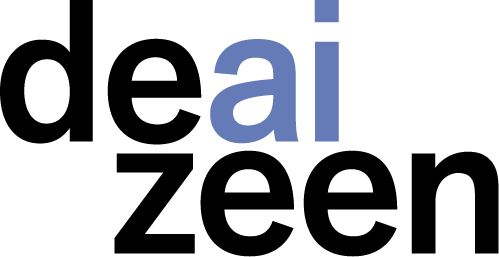

## Google Drive mount
I'm using Google Colaboratory as my default platform, therefore I need to set up my environment to integrate it with Google Drive. You can skip this bit if you're working locally.

1. Mount Google Drive on the runtime to be able to read and write files. This will ask you to log in to your Google Account and provide an authorization code.
2. Create a symbolic link to a working directory 
3. Change the directory to the one where I cloned my repository.


In [1]:
# mount Google Drive on the runtime
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
# create a symbolic link to a working directory
!ln -s /content/gdrive/My\ Drive/Colab\ Notebooks/dezeenAI /mydrive

# navigate to the working directory
%cd /mydrive

ln: failed to create symbolic link '/mydrive/dezeenAI': File exists
/content/gdrive/My Drive/Colab Notebooks/dezeenAI


## Install missing libraries

## Libraries & functions
- `numpy` - linear algebra
- `pandas` - data manipulation & analysis
- `matplotlib.pyplot` - data visualisation
- `cv2` - OpenCV computer vision library
- `sys` - system-specific parameters & functions


In [3]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

# Import DataFrames

## Articles

In [4]:
articles_df = pd.read_csv('files/df_articles.csv', index_col=0)
articles_df

,id,title,url
0,1596617,Freadman White completes Napier Street apartme...,https://www.dezeen.com/2020/12/14/napier-stree...
1,1596239,Meditation chambers by Office Of Things wash w...,https://www.dezeen.com/2020/12/13/meditation-r...
2,1594952,Library of law books wraps staircase in Mexico...,https://www.dezeen.com/2020/12/12/corporate-c-...
3,1596233,"""Grey alone would be too depressing for 2021's...",https://www.dezeen.com/2020/12/11/colour-of-th...
4,1595772,Seaside hotel by K-studio declared Ultimate Wi...,https://www.dezeen.com/2020/12/11/ultimate-win...
...,...,...,...
4985,70,Marcel Wanders launches Crochet Chair,https://www.dezeen.com/2006/12/10/marcel-wande...
4986,67,WOKmedia show at Design Miami,https://www.dezeen.com/2006/12/10/wokmedia-sho...
4987,54,Zaha Hadid furniture exhibited in New York,https://www.dezeen.com/2006/12/07/zaha-hadid-f...
4988,48,Thomas Heatherwick beach cafe takes shape,https://www.dezeen.com/2006/12/04/thomas-heath...


## Colors

In [5]:
colors_df = pd.read_pickle('files/df_images-colours.pkl')
colors_df

,id,url,path,colours,distribution
0,15,http://static.dezeen.com/uploads/2006/11/k.jpg,/mydrive/data/dezeen/15/k.jpg,"[[146.0, 122.92307692307692, 88.3076923076923]...","[0.05078125, 0.1640625, 0.05859375, 0.1875, 0...."
1,15,http://static.dezeen.com/uploads/2006/11/q.jpg,/mydrive/data/dezeen/15/q.jpg,"[[98.95348837209302, 82.30232558139535, 51.534...","[0.16796875, 0.05078125, 0.03515625, 0.0742187..."
2,15,http://static.dezeen.com/uploads/2006/11/c.jpg,/mydrive/data/dezeen/15/c.jpg,"[[71.50877192982456, 57.64912280701755, 35.912...","[0.22265625, 0.046875, 0.15234375, 0.13671875,..."
3,15,http://static.dezeen.com/uploads/2006/11/b.jpg,/mydrive/data/dezeen/15/b.jpg,"[[2.411764705882348, 8.54117647058824, 19.2000...","[0.33203125, 0.09375, 0.03515625, 0.06640625, ..."
4,15,https://static.dezeen.com/uploads/2006/11/1dez...,/mydrive/data/dezeen/15/1dezeen_november-07.jpg,"[[101.34146341463415, 80.46341463414635, 48.68...","[0.16015625, 0.06640625, 0.0625, 0.046875, 0.1..."
...,...,...,...,...,...
47224,1596617,https://static.dezeen.com/uploads/2020/12/napi...,/mydrive/data/dezeen/1596617/napier-street-mil...,"[[192.26666666666665, 177.86666666666667, 164....","[0.05859375, 0.234375, 0.078125, 0.0625, 0.074..."
47225,1596617,https://static.dezeen.com/uploads/2020/12/napi...,/mydrive/data/dezeen/1596617/napier-street-mil...,"[[147.8181818181818, 136.3181818181818, 131.27...","[0.0859375, 0.11328125, 0.15234375, 0.04296875..."
47226,1596617,https://static.dezeen.com/uploads/2020/12/napi...,/mydrive/data/dezeen/1596617/napier-street-mil...,"[[125.11111111111111, 97.38888888888889, 70.05...","[0.140625, 0.09765625, 0.05859375, 0.12890625,..."
47227,1596617,https://static.dezeen.com/uploads/2020/12/napi...,/mydrive/data/dezeen/1596617/napier-street-mil...,"[[83.22727272727272, 80.04545454545455, 21.590...","[0.0859375, 0.05859375, 0.203125, 0.1015625, 0..."


## Objects

In [6]:
objects_df = pd.read_csv('files/images_objectsbasic.csv', index_col=0)
objects_df

,id,url,path,person,person_conf,bicycle,bicycle_conf,car,car_conf,bench,bench_conf,cat,cat_conf,dog,dog_conf,sports ball,sports ball_conf,skateboard,skateboard_conf,bottle,bottle_conf,wine glass,wine glass_conf,cup,cup_conf,fork,fork_conf,knife,knife_conf,spoon,spoon_conf,bowl,bowl_conf,chair,chair_conf,sofa,sofa_conf,pottedplant,pottedplant_conf,bed,bed_conf,diningtable,diningtable_conf,toilet,toilet_conf,tvmonitor,tvmonitor_conf,laptop,laptop_conf,keyboard,keyboard_conf,microwave,microwave_conf,oven,oven_conf,sink,sink_conf,refrigerator,refrigerator_conf,book,book_conf,clock,clock_conf,vase,vase_conf
0,15,http://static.dezeen.com/uploads/2006/11/k.jpg,/mydrive/data/dezeen/15/k.jpg,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000
1,15,http://static.dezeen.com/uploads/2006/11/q.jpg,/mydrive/data/dezeen/15/q.jpg,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.350172,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000
2,15,http://static.dezeen.com/uploads/2006/11/c.jpg,/mydrive/data/dezeen/15/c.jpg,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000
3,15,http://static.dezeen.com/uploads/2006/11/b.jpg,/mydrive/data/dezeen/15/b.jpg,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000
4,15,https://static.dezeen.com/uploads/2006/11/1dez...,/mydrive/data/dezeen/15/1dezeen_november-07.jpg,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.000000,2,0.259486,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,1,0.32862,0,0.0,0,0.0,0,0.0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47224,1596617,https://static.dezeen.com/uploads/2020/12/napi...,/mydrive/data/dezeen/1596617/napier-street-mil...,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,0.491402,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.000000,3,0.389218,1,0.363451,0,0.000000,1,0.579165,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000
47225,1596617,https://static.dezeen.com/uploads/2020/12/napi...,/mydrive/data/dezeen/1596617/napier-street-mil...,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.000000,2,0.836554,0,0.000000,7,0.619697,0,0.000000,2,0.251881,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,1,0.661205
47226,1596617,https://static.dezeen.com/uploads/2020/12/napi...,/mydrive/data/dezeen/1596617/napier-street-mil...,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,4,0.293785,0,0.0,0,0.0,0,0.0,2,0.497962,4,0.567412,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.0,1,0.886706,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000
47227,1596617,https://static.dezeen.com/uploads/2020/12/napi...,/mydrive/data/dezeen/1596617/napier-street-mil...,0,0.0,0,0.0,10,0.745079,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.000000,1,0.267047,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000


# Object search

In [7]:
def objectGrid(class_name, sort='quantity', output=(4,4)):
  
  '''
  Takes the class name to find together with search parameters and outputs
  search results as a images grid.

  Parameters:
  class_name (str): Name of the class to find
  sort (str): sorting method
    `quantity` sort according to quantity of objects found (default)
    `confidence` sort according to find confidence
  output (tuple of integers): size of the image grid (rows, columns)

  Returns:
  An image grid with object search results
  '''

  # establish total number of elements to display
  number_of_elements = output[0] * output[1]

  # sort according to specified method
  if sort == 'quantity':
    df_search = objects_df.sort_values([class_name, class_name+'_conf'], ascending=False)
  elif sort == 'confidence':
    df_search = objects_df.sort_values([class_name+'_conf'], ascending=False)

  # fetch lists of image paths and article ids for search results
  paths = df_search['path'][:number_of_elements]
  ids = df_search['id'][:number_of_elements]

  # set up subplot according to output size
  fig, axs = plt.subplots(
      nrows=output[0],
      ncols=output[1],
      figsize=(output[1]*5, output[0]*5)
      )
  # set the main title
  fig.suptitle(f'Search results for "{class_name}"')

  # iterate through subplots to update their contents
  for n, ax in enumerate(axs.flat):

    # swtich of axis
    ax.axis('off')

    # retrieve article id and title
    id = ids.iloc[n]
    title = articles_df[articles_df['id'] == id]['title'].to_string(index=False)
    url = articles_df[articles_df['id'] == id]['url'].to_string(index=False)

    # set the title
    ax.set_title(
        title[:40]+
        '...\n'+
        url[:40]+'...'
        )

    # read the file
    image = cv2.imread(paths.iloc[n])

    # resize the image
    height, width = image.shape[:2]
    resized_image = cv2.resize(
      image,
      (2*width, 2*height),
      interpolation = cv2.INTER_CUBIC
      )
    
    # display image
    ax.imshow(
        cv2.cvtColor(
            resized_image,
            cv2.COLOR_BGR2RGB
            )
        )

In [8]:
objectGrid('sofa', sort='confidence', output=(10,4))

Output hidden; open in https://colab.research.google.com to view.

# Color search
Let's build a color search engine. To do it we will need two important functions:
- `rgb2hsv()` converts RGB color values to HSV
- `closestColor()` finds a color within a given list which distance is the closest to the refernece color

In [9]:
def rgb2hsv(color):

  '''
  Takes a color in RGB format and converts it HSV format.

  Parameters:
  color (list): Color in the RGB format as a list of R, G, B values

  Returns:
  A converted color in HSV format.
  '''
  
  r, g, b = color[0]/255.0, color[1]/255.0, color[2]/255.0
  mx = max(r, g, b)
  mn = min(r, g, b)
  df = mx-mn
  if mx == mn:
    h = 0
  elif mx == r:
    h = (60 * ((g-b)/df) + 360) % 360
  elif mx == g:
    h = (60 * ((b-r)/df) + 120) % 360
  elif mx == b:
    h = (60 * ((r-g)/df) + 240) % 360
  if mx == 0:
    s = 0
  else:
    s = (df/mx)*100
  
  v = mx*100
  color = [h, s, v]
  return color

In [10]:
def closestColor(reference_color, list_of_colors):

  '''
  Takes a reference color and finds a closest color withing a given color list.

  Parameters:
  reference_color (list): Reference color in a RGB format
  list_of_colors (list): List of colors in a RGB format

  Returns:
  A color within a list the closest to the reference color and distance between them.
  '''
  
  # initiate the distance to be a really big number and closest_color as empty
  shortest_distance, closest_color = sys.maxsize, None

  # check if the color container is not NaN
  if isinstance(list_of_colors, np.ndarray):
    
    # iterate through all the colors
    for color in list_of_colors:      
      # calculate the Euclidean distance to the reference color (sum of squared distances of each value)
      current_distance = pow(rgb2hsv(color)[0] - rgb2hsv(reference_color)[0], 2) + \
                         pow(rgb2hsv(color)[1] - rgb2hsv(reference_color)[1], 2) + \
                         pow(rgb2hsv(color)[2] - rgb2hsv(reference_color)[2], 2)


      # update the distance along with the corresponding color
      if current_distance < shortest_distance:
        shortest_distance = current_distance
        closest_color = color    

  return closest_color, shortest_distance

### Proof of concept
Let's ilustrate how the search engine works based on a random example.


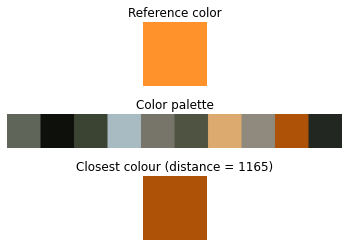

In [14]:
def plotClosestColor(reference_color=None, list_of_colors=None):

  '''
  Plots a visual representation of closestColor() function

  Parameters:
  reference_color (list): Reference color in a RGB format
  list_of_colors (list): List of colors in a RGB format

  Returns:
  A color within a list the closest to the reference color and distance between them.
  '''

  # pick random if reference color not specified
  if reference_color == None:    
    reference_color = [
                       np.random.randint(0, 255),
                       np.random.randint(0, 255),
                       np.random.randint(0, 255) 
                       ]

  # pick random if no list of colors specified
  if list_of_colors == None:    
    random_row = np.random.randint(0, colors_df.shape[0])
    list_of_colors = colors_df.iloc[random_row]['colours']
  

  # initiate a horizontal container of 50x50 boxes to be later filled with colors
  bar = np.zeros((50,50*10,3), dtype='uint8')

  # initiate drawing starting point
  startX = 0

  # draw rectangles for the colors in the list
  for color in list_of_colors:

    # set an ending point for a current box
    endX = startX + 50

    # draw a rectangle
    cv2.rectangle(
        bar,              # container
        (int(startX),0),  # start point
        (int(endX),50),   # end point
        color,            # color  
        -1                # fill rectangle
        )
    
    # set a starting point for a following box
    startX = endX

  # draw a rectangle for the reference color
  reference = np.zeros((50,50,3), dtype='uint8')
  cv2.rectangle(
      reference,            # container  
      (0, 0),               # start point
      (50, 50),             # end point
      (reference_color[0],  # R
       reference_color[1],  # G
       reference_color[2]), # B
      -1                    # fill rectangle
      )
  
  # find closest color
  closest = np.zeros((50,50,3), dtype='uint8')
  clo_col = closestColor(reference_color, list_of_colors)
  cv2.rectangle(
      closest,          # container
      (0, 0),           # start point
      (50, 50),         # end point
      (clo_col[0][0],   # R
       clo_col[0][1],   # G
       clo_col[0][2]),  # B
      -1                # fill rectangle
      )

  # plot the figure
  fig, axs = plt.subplots(3)

  axs[0].imshow(reference)
  axs[0].set_title('Reference color')
  axs[0].axis('off');

  axs[1].imshow(bar)
  axs[1].set_title('Color palette')
  axs[1].axis('off');

  axs[2].imshow(closest)
  axs[2].set_title('Closest colour (distance = {})'.format(int(clo_col[1])))
  axs[2].axis('off');

plotClosestColor(reference_color=[255, 146, 43])

### Actual engine

In [12]:
def ColorGrid(ref_col, output=(4,4)):
  
  '''
  Takes the color, finds pictures containing it and outputs search results as a image grid.

  Parameters:
  ref_col (list): Color in RGB formatting
  output (tuple of integers): size of the image grid (rows, columns)

  Returns:
  An image grid with color search results
  '''

  # establish total number of elements to display
  number_of_elements = output[0] * output[1]

  # find color distance for each image in the dataset and sort the DataFrame
  colors_df_search = colors_df.copy()
  colors_df_search['distance'] = colors_df.apply(lambda x: closestColor(ref_col, x.loc['colours'])[1], axis=1)
  colors_df_search.sort_values(['distance'], inplace=True)  

  # fetch lists of image paths and article ids for search results
  paths = colors_df_search['path'][:number_of_elements]
  ids = colors_df_search['id'][:number_of_elements]

  # set up subplot according to output size
  fig, axs = plt.subplots(
      nrows=output[0],
      ncols=output[1],
      figsize=(output[1]*5, output[0]*5)
      )
  # set the main title
  fig.suptitle(f'Search results for {ref_col}')

  # iterate through subplots to update their contents
  for n, ax in enumerate(axs.flat):

    # swtich of axis
    ax.axis('off')

    # retrieve article id and title
    id = ids.iloc[n]
    title = articles_df[articles_df['id'] == id]['title'].to_string(index=False)
    url = articles_df[articles_df['id'] == id]['url'].to_string(index=False)

    # set the title
    ax.set_title(
        title[:40]+
        '...\n'+
        url[:40]+'...'
        )

    # read the file
    image = cv2.imread(paths.iloc[n])

    # resize the image
    height, width = image.shape[:2]
    resized_image = cv2.resize(
      image,
      (2*width, 2*height),
      interpolation = cv2.INTER_CUBIC
      )
    
    # display image
    ax.imshow(
        cv2.cvtColor(
            resized_image,
            cv2.COLOR_BGR2RGB
            )
        )

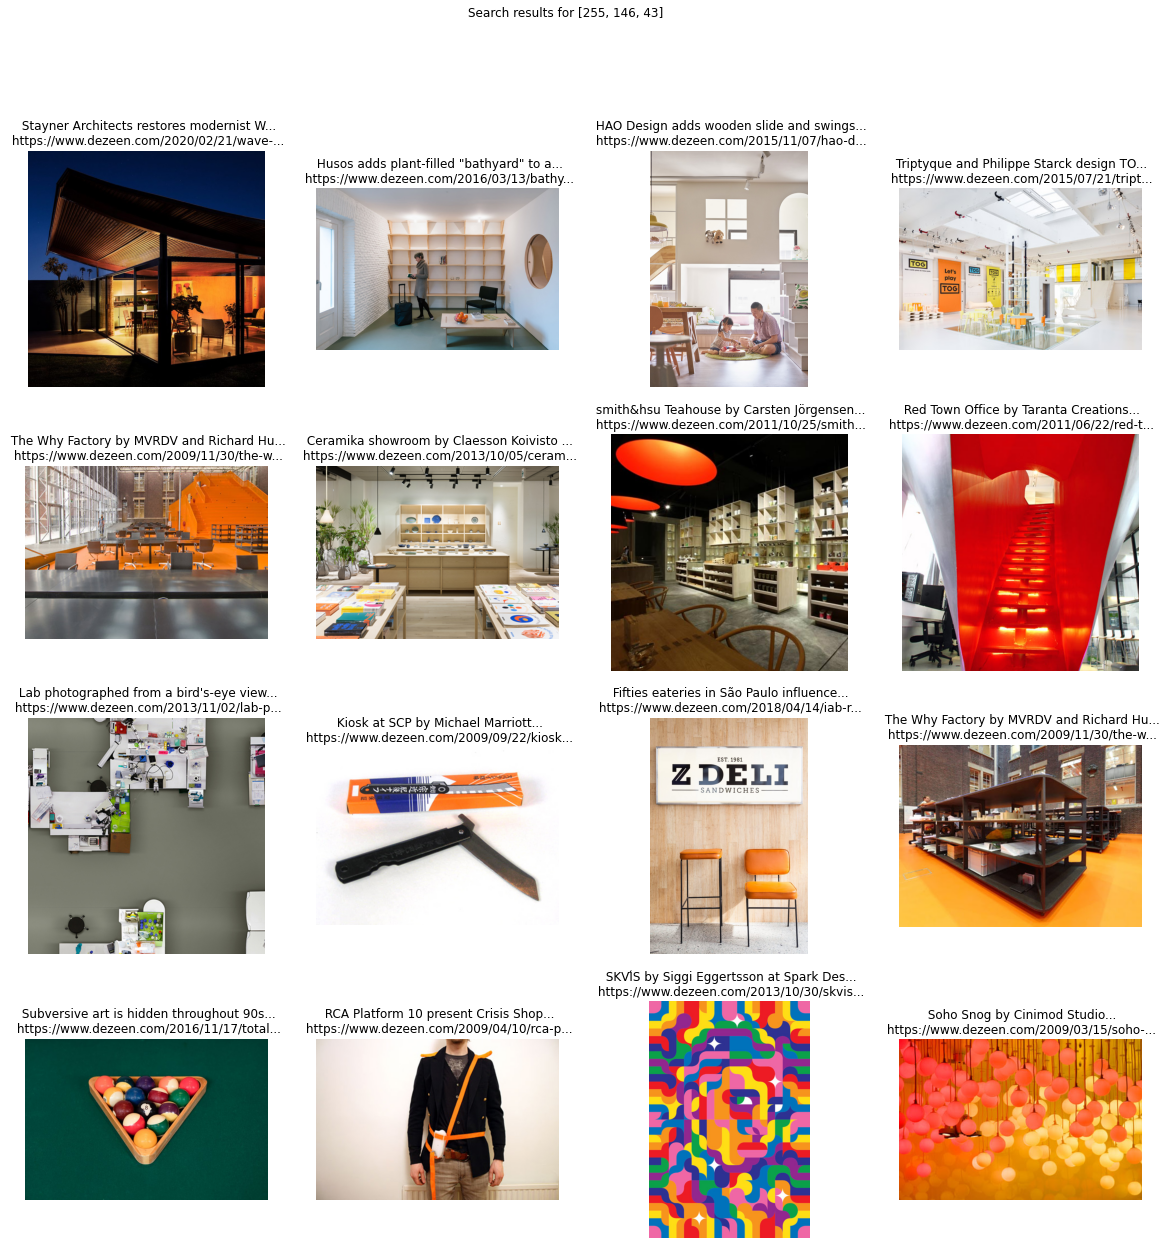

In [13]:
ref_col=[255, 146, 43]
ColorGrid(ref_col)